## Forecasting the 7 month weather outlook for New York City

IBM's Monthly seasonal forecasts (TWC-SPFP) provides essential insights into anticipated weather patterns over the coming months, aiding industries in strategic planning and decision-making. Utilizing advanced data analytics and artificial intelligence, this forecast analyzes historical weather data and current atmospheric conditions to predict trends in temperature, precipitation, and storm activity. It is particularly valuable for sectors such as agriculture, energy, and retail, where weather influences operations and profitability. By offering accessible forecasts through IBM's platforms, the Monthly seasonal forecasts enables organizations to optimize resources, enhance risk management, and better align their strategies with expected seasonal changes.
The TWC-SPFP offering consists of 50 equally likely scenarios.  Maximum, minimum and average temperature, as well as total precipitation forecasts, are offered, extending out to 6-months at daily resolution.  Forecasts are produced at monthly intervals (corresponding to the valid times of the forecasts), spanning from February 1981 to present.  The underlying data source is from the ECMWF-S5 climate model, which is calibrated against the ERA5 dataset.

This notebook is designed to extract and visualize weather forecasts using the Monthly seasonal forecasts data through the IBM Environmental Intelligence(EI): Geospatial APIs Python SDK (SDK).
In this analysis, the notebook will guide you through a series of steps that begin with installing the SDK and loading essential libraries. 
You will then specify the forecast time, length, and geographic coordinates (latitude and longitude) for your area of interest. 
Following that, the notebook will define the relevant geospatial layers and dates, compute temperature adjustments for maximum (TMAX) and average (TAVG) temperatures based on an adiabatic lapse rate scaling, and finally extract the forecast data, including mean and standard deviation. 
The notebook culminates in visualizing this data through informative plots, providing valuable insights into your selected weather forecast.

This notebook extracts the Monthly seasonal forecasts mean and standard deviation from IBM EI Geospatial APIs for a selected forecast and plots them

- Block 1 install the SDK
- Block 2 loads libraries and sets up the SDK
- Block 3 requires user to specify forecast time, forecast length & lat/lon location
- Block 4 defines datalayer numbers and dates
- Block 5 computes the temperature adjustment for TMAX and TAVG based on an adiabatic lapse rate scaling
- Block 6 extracts the forecast mean and standard deviation
- Block 7 plots the data

In [ ]:
%pip install ibmpairs
%pip install rasterio
%pip install folium
%pip install configparser
%pip install matplotlib

In [1]:
# Load Libraries and setup EI Geospatial python SDK 
import configparser

# ibmpairs
import ibmpairs.client as client 
import ibmpairs.query as query 

import numpy as np 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta 

# Define date format used for EI Geospatial
iso_8601 = "%Y-%m-%dT%H:%M:%SZ"

To get started with the SDK, follow the [installation](https://pages.github.ibm.com/physical-analytics/ibmpairs-internal/installation.html) instructions, then take a look at the [tutorials](https://pages.github.ibm.com/physical-analytics/ibmpairs-internal/tutorials/index.html).

**Note:** For the seamless execution of this notebook, kindly configure your EI Geospatial APIs credentials in a file named `secrets.ini`, following the prescribed format detailed below.

```
[EIS]
api.host = https://api.ibm.com/geospatial/run/na/core/v4
api.key = <Your EI Geospatial API key>
api.tenant_id = <Your EI Geospatial Tenant ID>
api.org_id = <Your EI Geospatial Org ID>
```

Keep secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../../auth/secrets.ini')```

In [ ]:
config = configparser.RawConfigParser()
config.read('../../../auth/secrets.ini')

# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_ORG_ID     = config.get('EI', 'api.org_id') 
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_API_KEY     = config.get('EI', 'api.api_key')

EI_client_v3 = client.get_client(org_id    = EI_ORG_ID,
                                  tenant_id = EI_TENANT_ID,
                                  api_key   = EI_API_KEY,
                                  version   = 3
                                )

## Specify forecast time, forecast length and station name with its latitude and longitude

The following code snippet is used to gather weather forecast data for a specific location. 

It selects the types of weather information to retrieve, such as precipitation, maximum and minimum temperatures, and average temperature. It sets the start date and determines how long the forecast should cover, looking ahead for 7 months from the chosen date. It specifies the location for which the weather data is fetched. 

By default, it is set to New York City, but it can be changed to another location if needed.

In [2]:
# Select weather variables
Variables = ["PRECIP","TMAX","TMIN","TAVG"]

# Choose forecast initialization time
start_forecast_date = datetime.strptime("2024-08-01", "%Y-%m-%d")

# How many months of forecast to query
# **Note that the forecast duration is 7 months from 2024, otherwise 6 months**
forecast_length_months = 7

# Specify station name and lat/lon
station_name = 'NYC'
lat, lon = 40.7128, -74.0060

print('Obtaining data for', station_name, "at", str(lat), str(lon))

Obtaining data for NYC at 40.7128 -74.006


### Define the datalayer numbers and forecast dates plus horizons


The code is designed to prepare and organize weather forecast data for analysis. 

First, it sets up different layers of data from various sources. For instance, it identifies specific codes for precipitation, maximum and minimum temperatures, and average temperature from two datasets: one from Monthly seasonal forecasts and the other from the ERA5 dataset, calculated by the IBM Future of Climate team. 
The ERA5 data spans 1991 to 2020 and follows a methodology similar to that used in the ERA-Interim climatology. It also includes codes for terrain elevation to correct temperature data.

Next, the code calculates the range of dates for which forecast data will be gathered. 
It starts from a specified beginning date and extends for a set number of months.

In [ ]:
# Designate datalayers for query

# Monthly seasonal forecasts
layers_TWC = {"PRECIP": 50686, "TMIN": 50683, "TMAX": 50684, "TAVG": 50685}

# ERA5 1991-2020 Climatology
layers_ERA5 = {"PRECIP": 51198, "TMIN": 51217, "TMAX": 51200, "TAVG": 51199}

# Terrain elevation height for adiabatic lapse rate correction of TMAX and TAVG
layers_ELEVATION = {"twc_elevation": 51219, "srtm_elevation": 49506}

# Compute the list of valid_dates and horizons used to make the EI Geospatial query
valid_dates_horizons = []
count = 0
date = start_forecast_date
while date < start_forecast_date + relativedelta(months=forecast_length_months):
    valid_date = start_forecast_date + timedelta(days=count)
    horizon = (valid_date - start_forecast_date).days
    valid_dates_horizons.append([valid_date, horizon])
    count += 1
    date += timedelta(days=1)

print('Forecast Start Date:', valid_dates_horizons[0][0])
print('Forecast End Date:', valid_dates_horizons[-1][0])

Forecast Start Date: 2024-08-01 00:00:00
Forecast End Date: 2025-02-28 00:00:00


### Compute the temperature adjustment for TMAX and TAVG 
The adjustment is based on an adiabatic lapse rate scaling. It uses difference in surface elevation between the TWC-SPFP model and Digital Elevation Model SRTM ("truth") extracted from  EI Geospatial APIs.


The code is designed to retrieve and use elevation data to adjust temperature measurements. First, it sets up a way to collect elevation information from two different sources. Using the latitude and longitude of a location, it queries these sources for the most recent elevation data available.

After fetching the elevation data, the code calculates the difference between the elevations from the two sources. It then uses this difference to adjust temperature readings. Specifically, it applies a correction factor to account for variations in elevation, which affects how temperature data should be interpreted.

In [7]:
# Define dictionary to store the height for TWC and SRTM 
elevation = {}
for VARIABLE in ["twc_elevation","srtm_elevation"]:
    
    # Create json string to query
    query_json = {
    "layers" : [
        {"type" : "raster", "id" : layers_ELEVATION[VARIABLE]}
    ],
    "spatial" : {"type" : "point", "coordinates" : [lat, lon]},
    "temporal" : {"intervals" : [
                                    # used the latest elevation height available in the system
                                    {"snapshot" : "2020-01-01T00:00:00Z"}
                                ]}
                 }
    
    # Submit query
    df = query.submit(query_json).point_data_as_dataframe()

    # Extract elevation data
    if (len(df) > 0):    
        elevation[VARIABLE] = float(df.iloc[0]['value'])

# Compute lapse-rate correction for temperature 
elevation_diff = elevation['srtm_elevation'] - elevation['twc_elevation']
temperature_adjustment = elevation_diff*(-0.0098)

print('SRTM elevation: '+str(elevation['srtm_elevation'])+' m, TWC elevation: '+str(elevation['twc_elevation'])+' m')
print('')
print('Temperature adjustment of '+str(np.round(temperature_adjustment,3))+' C to be applied to TMAX and TAVG')

2024-09-20 20:28:18 - paw - INFO - TASK: submit STARTING.
2024-09-20 20:28:19 - paw - INFO - TASK: submit COMPLETED.
2024-09-20 20:28:19 - paw - INFO - TASK: submit STARTING.
2024-09-20 20:28:21 - paw - INFO - TASK: submit COMPLETED.
SRTM elevation: 24.855470657348633 m, TWC elevation: 42.076717376708984 m

Temperature adjustment of 0.169 C to be applied to TMAX and TAVG


### Extract Monthly seasonal forecasts data 

 > Note: it only extracts the mean and standard deviation. See other sample notebooks for extracting prototypes

The extracted data is stored in two variables: 

twc_dates [Variable] <-- a list of dates

twc_values [Variable, date, mean or std-dev]  <-- a 3D array for each variable, each date, and each statistic



The following code snippet collects and organize weather forecast data from a database for different weather variables like temperature and precipitation.

1. **Initialize Storage**: It sets up an empty array to store the weather data for each variable, date, and statistic (mean or standard deviation).

2. **Query Data**: For each type of weather variable (such as temperature or precipitation), the code constructs and sends a query to the database. This query is customized for each date and forecast period, and it requests two types of statistics: the mean and the standard deviation.

3. **Process Results**: After receiving the data, the code extracts relevant information, such as the date, type of statistic, and the actual values. It adjusts the temperature values for elevation and converts them from Kelvin to Celsius where necessary. It then stores this information in the previously set up array.

4. **Error Check**: Finally, the code performs a check to ensure that all expected data has been retrieved correctly. If there is a mismatch between the dates and the data values, it prints an error message to indicate a potential problem.

In summary, this code collects detailed weather forecast data, adjusts it for accuracy, and stores it in an organized way for further analysis.

In [8]:
#---------
# Initialize array for storing values. Returned data will be stored in the array "values":
# values = [Variable, date, mean or std-dev]
twc_values = np.zeros((len(Variables),len(valid_dates_horizons[:]),2))

#---------
# Construct, submit and parse query

# Cycle through each variable
for var_count, variable in enumerate(Variables):
    
    print('Querying data for:', variable)

    #---------
    # Create json to query the system
    # The query_json loops through valid_dates_horizons to create individual interval queries for each valid_date and forecast horizon
    # It also loops through two statistics – "mean" and "std" – to extract data from these two dimensions
    query_json = {
    "layers": [
        {
            "type": "raster",
            "id": layers_TWC[variable],
            "temporal": {
                "intervals": [
                    {
                        "start": (valid_date-timedelta(seconds=60)).strftime(iso_8601),
                        "end": (valid_date+timedelta(seconds=60)).strftime(iso_8601),                        
                    }
                ]
            },
            "dimensions": [
                {"name": "forecast", "value": ens},
                {"name": "horizon", "value": horizon},
            ],
        }
        for valid_date, horizon in valid_dates_horizons
        for ens in ["mean","std"]
    ],

    "spatial": {"type": "point", "coordinates": [lat, lon]},

    # This is the default time-range (to be used if a time-range isn't given in the above blocks.)
    # It is required, even though the information might not be used.
    "temporal": {"intervals": [{"snapshot": "2020-01-01"}]},
    "outputType": "json"
    }

    # Submit query
    df = query.submit(query_json).point_data_as_dataframe()

    # Extract data from query return, cycling through each date
    twc_dates = []
    for index, row in df.iterrows():
        
        # Extract returned data from query object
        date = row['timestamp']
        statistic = row['property'].split(";")[0].split(":")[1]
        horizon = int(row['property'].split(";")[1].split(":")[1].strip('"'))
        value = float(row['value'])
        
        # Keep count of the unique dates in the returned query to ensure we place them in "values" correctly
        if date not in twc_dates:
            date_count = len(twc_dates)
            twc_dates.append(date)
        
        # Place returned data into correct location of "values"
        if statistic == "mean":
            
            # TMAX & TAVG: apply T-adjustment and convert from K to C
            if variable == "TMAX" or variable == "TAVG":
                twc_values[var_count,date_count,0] = value + temperature_adjustment - 273.15
            # TMIN: convert from K to C
            elif variable == "TMIN":
                twc_values[var_count,date_count,0] = value - 273.15
            # PRECIP
            elif variable == "PRECIP":
                twc_values[var_count,date_count,0] = value
            
        elif statistic == "std":
            twc_values[var_count,date_count,1] = value

    print('------------Completed Query--------------')

# Here's a quick error check in case of missing data in the system
# If the length of the unique dates list does not match the length of any of the extracted values then we have a problem
if len(twc_dates) != len(twc_values[0,:,0]) or len(twc_dates) != len(twc_values[1,:,0]):
    print('WE HAVE A PROBLEM!')
    print('Length of date array and value array do not match.')
    print('Possible issue is selected forecast horizon length: max forecast horizon = 7 months from August 2024, otherwise 6 months.')
    

Querying data for: PRECIP
2024-09-20 20:28:46 - paw - INFO - TASK: submit STARTING.
2024-09-20 20:31:03 - paw - INFO - TASK: submit COMPLETED.
------------Completed Query--------------
Querying data for: TMAX
2024-09-20 20:31:03 - paw - INFO - TASK: submit STARTING.
2024-09-20 20:33:19 - paw - INFO - TASK: submit COMPLETED.
------------Completed Query--------------
Querying data for: TMIN
2024-09-20 20:33:19 - paw - INFO - TASK: submit STARTING.
2024-09-20 20:35:32 - paw - INFO - TASK: submit COMPLETED.
------------Completed Query--------------
Querying data for: TAVG
2024-09-20 20:35:32 - paw - INFO - TASK: submit STARTING.
2024-09-20 20:37:27 - paw - INFO - TASK: submit COMPLETED.
------------Completed Query--------------


### Extract ERA5 climatology (1991-2020) for each variable

The below code snippet help retrieves and processes climatology data for a specific location and time period. 
It starts by initializing empty lists to store dates and values. 
For each climate variable, it constructs a query to get daily climatology data for an entire year from a database. 
After receiving this data, it extracts the relevant dates and values.

The code then matches these extracted dates to a set of forecast dates. 
For each forecast date, it finds the corresponding climatology value and adjusts it if necessary.

In [9]:
# Initialize lists for storing values
climo_dates = []
climo_values = []

# Loop through each variable in turn
for variable in Variables:
    
    print('Querying data for:', variable)
    
    # Here we query the entire year of daily climatology data
    query_json = {
        "layers" : [
                     {"type" : "raster", "id" : layers_ERA5[variable]}
                   ],
        "spatial" : {"type" : "point", "coordinates" : [lat, lon]},  
        "temporal": {"intervals" : [
                        {"start" :  "2019-12-31T23:59:00Z", "end" : "2020-12-31T00:01:00Z"}
                   ]}
    }

    # run a point query to get climatology data back
    df = query.submit(query_json).point_data_as_dataframe()
    
    # Extract dates and values from query and convert to a list
    climo_dates_variable = df["timestamp"].tolist()
    climo_values_variable = df["value"].tolist()

    # Create temporary lists for storing data
    dates_var = []
    values_var = []

    # We have extracted a full year of climatology data – which is year-agnostic – which we need to re-order to match the forecast dates 
    # Cycle through forecast dates and extract respective climatology values. Create a new climatology date list to match the forecast dates
    for date, horizon in valid_dates_horizons:
        
        # Append forecast date to new date list for climatology
        dates_var.append(date)
        
        # Convert forecst date to np.datetime64 object to find its matching index in the climatology date list
        search_date = np.datetime64("2020-"+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)+'T00:00:00.000000000')
        search_date = int(search_date.astype(datetime) / 1000000)
        
        # Find index of matching forecast date in the climatology date list
        if search_date in climo_dates_variable:
            index = climo_dates_variable.index(search_date)
        
        # Append climatology value to the new list ordered by forecast date 
        # TMAX & TAVG: apply T-adjustment and convert from K to C
        if variable == "TMAX" or variable == "TAVG":
            float_value = float(climo_values_variable[index])
            adjusted_value = float_value + float(temperature_adjustment) - 273.15
            values_var.append(adjusted_value)
        # TMIN: convert from K to C
        elif variable == "TMIN":
            float_value = float(climo_values_variable[index])
            adjusted_value = float_value - 273.15
            values_var.append(adjusted_value)
        # PRECIP
        elif variable == "PRECIP":
            values_var.append(float(climo_values_variable[index]))        
        
    climo_dates.append(dates_var)
    climo_values.append(values_var)

print('------------Completed Climatology Query--------------')

Querying data for: PRECIP
2024-09-20 20:37:57 - paw - INFO - TASK: submit STARTING.
2024-09-20 20:38:21 - paw - INFO - TASK: submit COMPLETED.
Querying data for: TMAX
2024-09-20 20:38:21 - paw - INFO - TASK: submit STARTING.
2024-09-20 20:38:34 - paw - INFO - TASK: submit COMPLETED.
Querying data for: TMIN
2024-09-20 20:38:34 - paw - INFO - TASK: submit STARTING.
2024-09-20 20:38:56 - paw - INFO - TASK: submit COMPLETED.
Querying data for: TAVG
2024-09-20 20:38:56 - paw - INFO - TASK: submit STARTING.
2024-09-20 20:39:21 - paw - INFO - TASK: submit COMPLETED.
------------Completed Climatology Query--------------


### Plot the returned data with the climatology (red line)

The code helps in plotting the graph with the returned data by comparing the predictions for 2024-2025 with the climatology based on the ERA5 dataset from 1991-2020.

The graph visually represents how current weather data compares to historical averages, highlighting both predictions and their uncertainties for New York City (NYC) from August 2024 to March 2025. Here's a simple breakdown of each:

NYC Precip (Precipitation)

- The red line represents the historical average precipitation from 1991-2020 (ERA5 data).
- The blue line shows the predicted precipitation for 2024-2025, with the blue shaded area representing the uncertainty in the prediction.
- The blue line has many spikes, indicating higher variability in recent weather predictions, whereas the red line is much steadier, showing historical averages.
    
NYC TMAX (Maximum Temperature)

- The red line represents the average maximum temperature from 1991-2020.
- The blue line shows the predicted maximum temperature for 2024-2025. Both lines decrease over time, moving from the summer heat to winter cold.
- The blue shaded area reflects uncertainty in the temperature predictions, showing how predictions might deviate from the average.
    
NYC TMIN (Minimum Temperature)

- The red line represents the historical average minimum temperature, while the blue line shows the predicted minimum temperatures for 2024-2025.
- As temperatures decline over time, you can compare how the recent predictions align with the historical averages, with a little variation between them.
    
NYC TAVG (Average Temperature)

- The red line here represents the historical average daily temperature (from 1991-2020), while the blue line represents the predicted average daily temperature.
- The trend shows temperatures steadily falling, and the shaded blue area again indicates the uncertainty in the predictions compared to the historical averages.
    
In summary, the red line gives you a historical climate benchmark, while the blue line and shaded area show predictions for the recent period and how much they may vary from the historical norm. This comparison helps identify how current weather might be different from long-term climate trends.

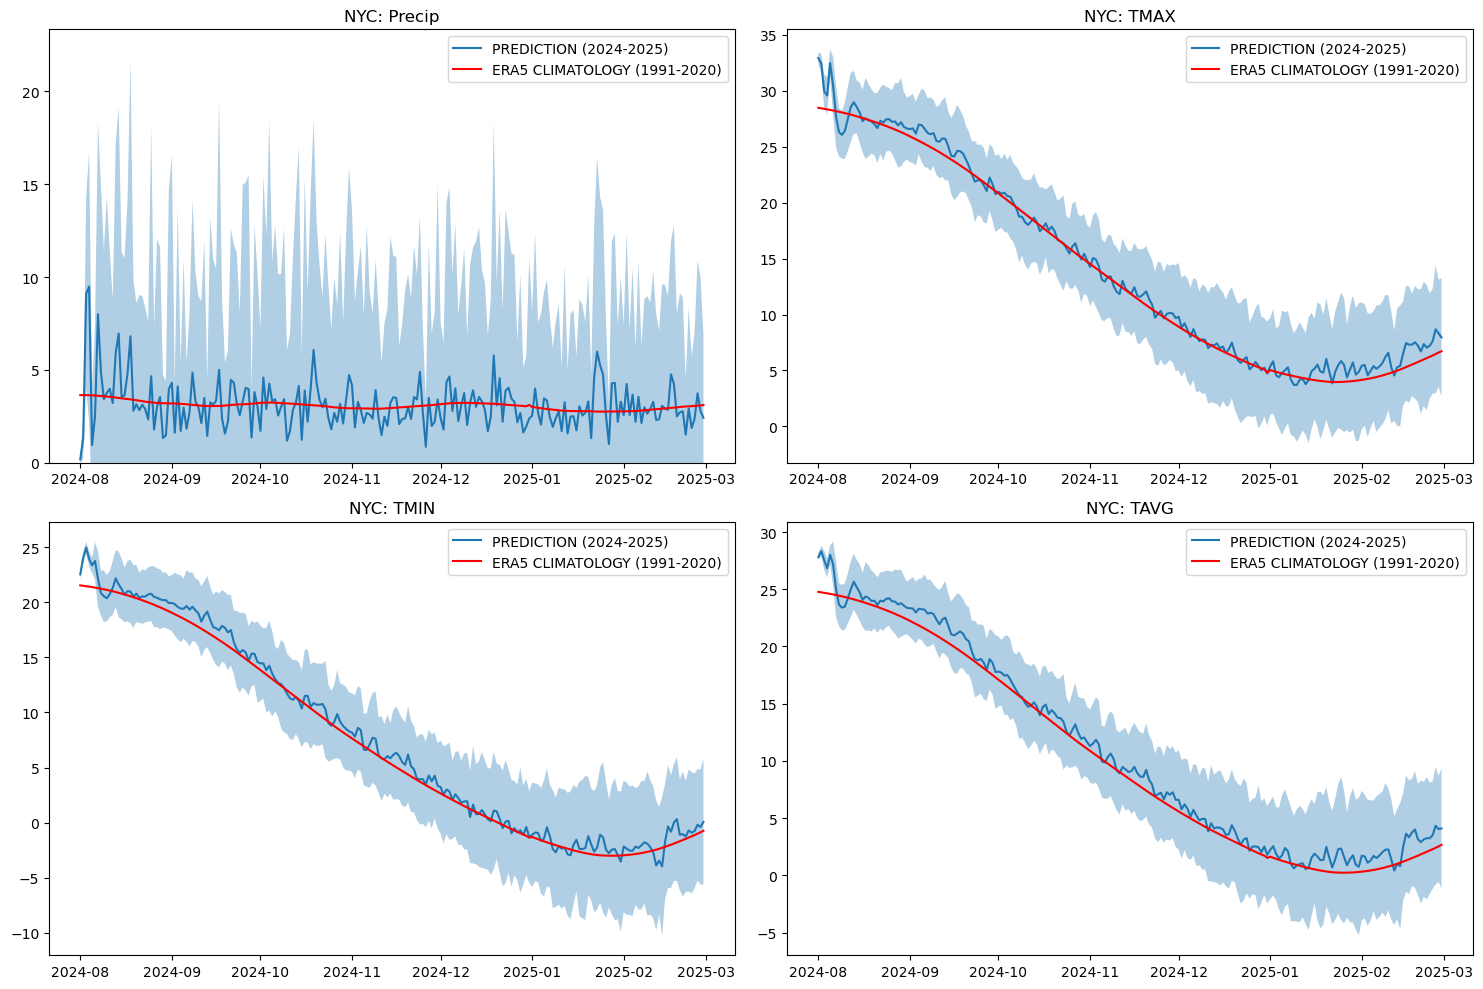

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def unix_to_datetime(unix_timestamp):
    return datetime.fromtimestamp(unix_timestamp / 1000.0)

# function to check and convert twc_dates
def ensure_datetime(twc_dates):
    if isinstance(twc_dates[0], datetime):
        # already in datetime format
        return twc_dates
    elif isinstance(twc_dates[0], (int, float)):
        return [unix_to_datetime(ts) for ts in twc_dates]
    else:
        raise ValueError("twc_dates is not in an expected format")


fig, ax = plt.subplots(2, 2, figsize=(15,10))
twc_dates = ensure_datetime(twc_dates)
formatter = mdates.DateFormatter("%Y-%m")

ax[0,0].plot(twc_dates, twc_values[0,:,0], label='PREDICTION (2024-2025)')
ax[0,0].plot(climo_dates[0], climo_values[0], color="red", label='ERA5 CLIMATOLOGY (1991-2020)')
ax[0,0].fill_between(twc_dates, twc_values[0,:,0]-twc_values[0,:,1], twc_values[0,:,0]+twc_values[0,:,1], alpha=0.35)
ax[0,0].set_ylim(bottom=0)
ax[0,0].set_title( station_name+': Precip')
ax[0,0].legend()

ax[0,1].plot(twc_dates, twc_values[1,:,0], label='PREDICTION (2024-2025)')
ax[0,1].plot(climo_dates[1], climo_values[1], color="red", label='ERA5 CLIMATOLOGY (1991-2020)')
ax[0,1].fill_between(twc_dates, twc_values[1,:,0]-twc_values[1,:,1], twc_values[1,:,0]+twc_values[1,:,1], alpha=0.35)
ax[0,1].set_title(station_name+': TMAX')
ax[0,1].legend()

ax[1,0].plot(twc_dates, twc_values[2,:,0], label='PREDICTION (2024-2025)')
ax[1,0].plot(climo_dates[2], climo_values[2], color="red", label='ERA5 CLIMATOLOGY (1991-2020)')
ax[1,0].fill_between(twc_dates, twc_values[2,:,0]-twc_values[2,:,1], twc_values[2,:,0]+twc_values[2,:,1], alpha=0.35)
ax[1,0].set_title(station_name+': TMIN')
ax[1,0].legend()

ax[1,1].plot(twc_dates, twc_values[3,:,0], label='PREDICTION (2024-2025)')
ax[1,1].plot(climo_dates[3], climo_values[3], color="red", label='ERA5 CLIMATOLOGY (1991-2020)')
ax[1,1].fill_between(twc_dates, twc_values[3,:,0]-twc_values[3,:,1], twc_values[3,:,0]+twc_values[3,:,1], alpha=0.35)
ax[1,1].set_title(station_name+': TAVG')
ax[1,1].legend()

formatter = mdates.DateFormatter("%Y-%m")
ax[0,0].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

### Plot the returned data as an anomaly (departure from climatology)

The code helps visualize weather data by creating a series of plots for different weather variables for NYC location.

The graph visually represents how current weather data compares to historical averages, highlighting both predictions and their uncertainties

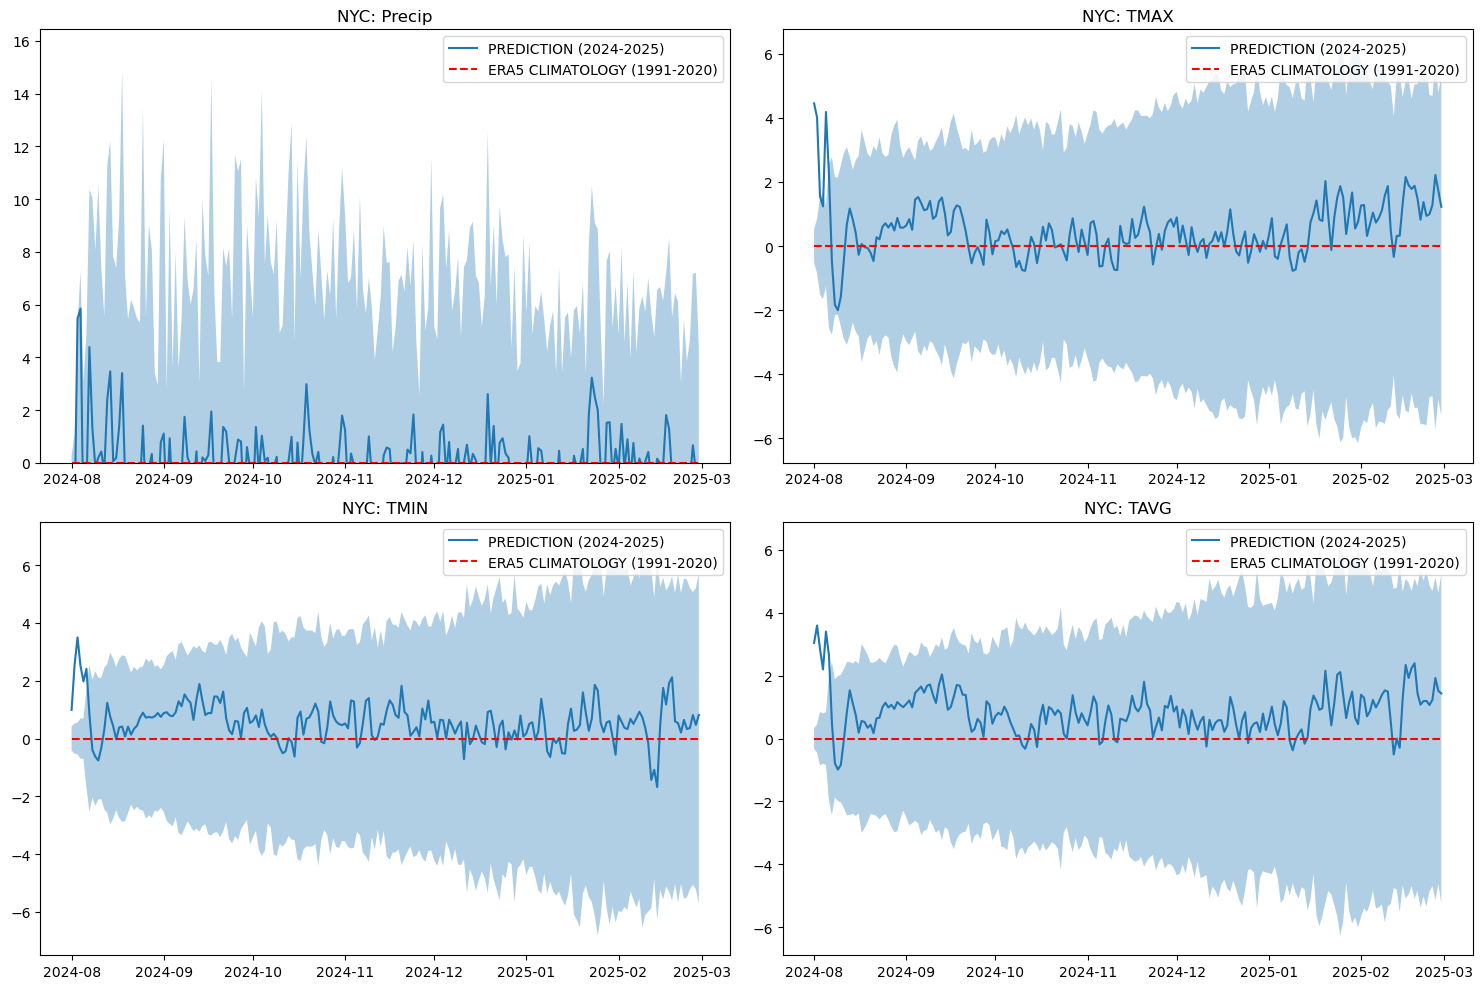

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0,0].plot(twc_dates, twc_values[0,:,0]-climo_values[0], label='PREDICTION (2024-2025)')
ax[0,0].plot(climo_dates[0], [0]*len(climo_dates[0]), color="red", linestyle='--', label='ERA5 CLIMATOLOGY (1991-2020)')
ax[0,0].fill_between(twc_dates, 0-twc_values[0,:,1], 0+twc_values[0,:,1], alpha=0.35)
ax[0,0].set_ylim(bottom=0)
ax[0,0].set_title( station_name+': Precip')
ax[0,0].legend()

ax[0,1].plot(twc_dates, twc_values[1,:,0]-climo_values[1], label='PREDICTION (2024-2025)')
ax[0,1].plot(climo_dates[1], [0]*len(climo_dates[1]), color="red", linestyle='--', label='ERA5 CLIMATOLOGY (1991-2020)')
ax[0,1].fill_between(twc_dates, 0-twc_values[1,:,1], 0+twc_values[1,:,1], alpha=0.35)
ax[0,1].set_title(station_name+': TMAX')
ax[0,1].legend()

ax[1,0].plot(twc_dates, twc_values[2,:,0]-climo_values[2], label='PREDICTION (2024-2025)')
ax[1,0].plot(climo_dates[2], [0]*len(climo_dates[2]), color="red", linestyle='--', label='ERA5 CLIMATOLOGY (1991-2020)')
ax[1,0].fill_between(twc_dates, 0-twc_values[2,:,1], 0+twc_values[2,:,1], alpha=0.35)
ax[1,0].set_title(station_name+': TMIN')
ax[1,0].legend()

ax[1,1].plot(twc_dates, twc_values[3,:,0]-climo_values[3], label='PREDICTION (2024-2025)')
ax[1,1].plot(climo_dates[3], [0]*len(climo_dates[3]), color="red", linestyle='--', label='ERA5 CLIMATOLOGY (1991-2020)')
ax[1,1].fill_between(twc_dates, 0-twc_values[3,:,1], 0+twc_values[3,:,1], alpha=0.35)
ax[1,1].set_title(station_name+': TAVG')
ax[1,1].legend()

formatter = mdates.DateFormatter("%Y-%m")
ax[0,0].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()